<a href="https://colab.research.google.com/github/kimhwijin/HandsOnMachineLearing/blob/main/Reinforcement_Learning_18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial Display Settings

In [1]:
!apt-get install -y xvfb x11-utils
!pip install gym[all]==0.17.* pyvirtualdisplay==0.2.* PyOpenGL==3.1.* PyOpenGL-accelerate==3.1.*
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1


Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsight-10-1 cuda-nsight-11-0 cuda-nsight-11-1 cuda-nsight-compute-10-0
  cuda-nsight-compute-10-1 cuda-nsight-compute-11-0 cuda-nsight-compute-11-1
  cuda-nsight-systems-10-1 cuda-nsight-systems-

In [14]:
import gym
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib as mpl
from tensorflow import keras
import tensorflow as tf
import numpy as np
from collections import deque
mpl.rc('animation', html='jshtml')

In [5]:
display = Display(visible=0, size=(600, 400))
display.start()

# Make CartPole V1

In [6]:
env = gym.make("CartPole-v1")
obs = env.reset()
obs

array([ 0.02155794, -0.04000929,  0.00650975,  0.01618181])

In [6]:
env.render()

True

In [7]:
image = env.render(mode="rgb_array")
image.shape

(400, 600, 3)

In [8]:
env.action_space

Discrete(2)

In [9]:
action = 1
obs, reward, done, info = env.step(action)
obs, reward, done, info

(array([-0.01096227,  0.22304321, -0.01896007, -0.25703655]), 1.0, False, {})

# Basic Policy ( Not NN )

In [ ]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs = env.reset()
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, info = env.step(action)
        episode_rewards += reward
        if done:
            break

    totals.append(episode_rewards)
    

In [ ]:
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.626, 8.834598123287783, 24.0, 72.0)

In [7]:
def plot_environment(env, figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode="rgb_array")
    plt.imshow(img)
    plt.axis("off")
    return img


def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

In [ ]:
env.seed(42)
frames = []
obs = env.reset()
for step in range(200):
    img = env.render(mode="rgb_array")
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

plot_animation(frames)

# NN Policy

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = env.observation_space.shape[0]

model = keras.models.Sequential([
    keras.layers.Dense(5, activation='selu', input_shape=[n_inputs]),
    keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
def render_policy_net(model, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1")
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode="rgb_array"))
        left_proba = model.predict(obs.reshape(1, -1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames


In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

2022-02-08 19:51:57.559671: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-08 19:51:57.561862: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-02-08 19:51:57.594700: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [ ]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()


Iteration: 4999, Loss: 0.029

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

#Policy Gradient

In [ ]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        # 모델은 왼쪽으로 움직일 확률을 반환한다.
        left_proba = model(obs[np.newaxis])
        # 정규분포를 샘플링을 통해 확률에 따라 랜덤하게 행동을 선택한다.
        action = (tf.random.uniform([1, 1]) > left_proba)
        # 행동이 왼쪽이면 타깃확률은 1 이고, 오른쪽이면 0 이되도록 타깃을 지정한다. 즉 모든 행동이 옳다고 여김
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        # 이걸로 비용함수를 구한다.
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))
    
    #모델 파라미터의 기울기를 구한다.
    grads = tape.gradient(loss, model.trainable_variables)
    #확률로 랜덤하게 정한 행동으로 스텝을 진행한다.
    obs, reward, done, info = env.step(int(action[0, 0].numpy()))
    return obs, reward, done, grads

def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        #각 에피소드는 각 스텝의 보상들과 기울기들을 저장한다.
        current_rewards = []
        current_grads = []
        obs = env.reset()
        for step in range(n_max_steps):
            #각 스텝은 보상과 기울기를 저장한다.
            obs, reward, done, grads = play_one_step(env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done:
                break
        all_rewards.append(current_rewards)
        all_grads.append(current_grads)
    return all_rewards, all_grads

In [ ]:
#할인 보상
def discount_rewards(rewards, discount_rate):
    discounted = np.array(rewards)
    #할인된 미래보상을 중첩해서 현재에 더해야 하기때문에, 끝에서부터 계산한다.
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_rate
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_rate):
    #각 할인된 보상
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    
    #1차원 배열로 변경
    flat_rewards = np.concatenate(all_discounted_rewards)
    #평균
    reward_mean = flat_rewards.mean()
    #표준편차
    reward_std = flat_rewards.std()
    #각 할인 보상에 정규화
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

In [ ]:
#반복 수
n_iterations = 150
#매 반복마다 수행할 에피소드의 수
n_episodes_per_update = 10
#각 에피소드의 최대 스텝수
n_max_steps = 200
#감마
discount_rate = 0.95

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.01)
loss_fn = keras.losses.binary_crossentropy

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(5, activation="elu", input_shape=[4]),
    keras.layers.Dense(1, activation="sigmoid"),
])


# Policy Gradient Train

In [ ]:
env = gym.make("CartPole-v1")
env.seed(42)


for iteration in range(n_iterations):
    #n_episdoes_per_update 만큼 에피소드를 진행하고, 각 스텝마다 model 예측과 loss_fn에 따라 그레디언트를 구한다.
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    
    #여러 에피소드의 보상합
    total_rewards = sum(map(sum, all_rewards))                     # Not shown in the book
    print("\rIteration: {}, mean rewards: {:.1f}".format(          # Not shown
        iteration, total_rewards / n_episodes_per_update), end="") # Not shown
    
    #보상 정규화
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_rate)


    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            #각 에피소드별, 각 스텝별, 각 모델 파라미터별 그레디언트와 보상을 곱해서 적용한다.
            [final_reward * all_grads[episode_index][step][var_index]
            #에피소드 별 보상
             for episode_index, final_rewards in enumerate(all_final_rewards)
                #스텝 별 보상
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)
    #여러번의 에피소드에서 모아둔 그레디언트를 보상과 곱해서 평균한후 한꺼번에 적용시킨다.
    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

env.close()

Iteration: 149, mean rewards: 185.0

In [ ]:
frames = render_policy_net(model)
plot_animation(frames)

# Markov Decision Process

In [ ]:
transition_probabilities = [ # shape=[s, a, s']
        [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
        [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
        [None, [0.8, 0.1, 0.1], None]]
rewards = [ # shape=[s, a, s']
        [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
        [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
        [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]]
possible_actions = [[0, 1, 2], [0, 2], [1]]

In [ ]:
#state : 3개, 모든 가능한 행동 : 3개
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동은 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해

In [ ]:
gamma = 0.90  # 할인 계수

history1 = []
#Q-value 반복
for iteration in range(50):
    Q_prev = Q_values.copy()
    #Q_prev : 이전 행동에 따른 보상의 합, 이번 상태에 오기전까지 Q-value
    history1.append(Q_prev)
    #상태 0 1 2
    for s in range(3):
        #행동 0 ... 2
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    #전이 확률
                    transition_probabilities[s][a][sp]
                    #곱하기 (현재 보상 + 할인된 과거 보상의 합)
                    * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp]))
                #모든 s에 대해서
                for sp in range(3)])

history1 = np.array(history1)

In [ ]:
print(Q_values, np.argmax(Q_values, axis=1), sep='\n')
# 상태 0 -> 행동 0, 상태 1 -> 행동 0, 상태 2 -> 행동 1

[[18.91891892 17.02702702 13.62162162]
 [ 0.                -inf -4.87971488]
 [       -inf 50.13365013        -inf]]
[0 0 1]


In [ ]:
#할인 계수를 높임 -> 미래가치에 더 높은 가중치를 둠
Q_values = np.full((3, 3), -np.inf) # 불가능한 행동에 대해서는 -np.inf
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0.0  # 모든 가능한 행동에 대해서

gamma = 0.95  # 할인 계수
for iteration in range(50):
    Q_prev = Q_values.copy()
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp] * (rewards[s][a][sp] + gamma * np.max(Q_prev[sp])) for sp in range(3)
                    ])


In [ ]:
print(Q_values, np.argmax(Q_values, axis=1), sep='\n')
# 상태 0 -> 행동 0, 상태 1 -> 행동 2, 상태 2 -> 행동 1

[[21.73304188 20.63807938 16.70138772]
 [ 0.95462106        -inf  1.01361207]
 [       -inf 53.70728682        -inf]]
[0 2 1]


# Q-learning

In [ ]:
#에이전트가 전이확률과 보상을 모르기때문에, 환경을 만들어줘야한다.
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward


#에이전트가 다음행동을 결정하는 정책 -> 여기선 랜덤
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

In [ ]:
np.random.seed(42)

#Q-value 초기화
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state][actions] = 0


alpha0 = 0.05 # 초기 학습률
decay = 0.005 # 학습률 감쇄
gamma = 0.90 # 할인 계수
state = 0 # 초기 상태
history2 = []

#탐험수
for iteration in range(10000):
    history2.append(Q_values.copy())
    
    #탐험 정책에 따라서 현재 상태에 다음 행동을 결정한다.
    action = exploration_policy(state)
    #현재 상태와 행동을 통해서 확률적으로 다음 상태와 보상을 받는다.
    next_state, reward = step(state, action)
    #미래에 최적의 행동을 한다고 가정하고, 다음 상태의 최대 Q-value 를 받는다.
    next_value = np.max(Q_values[next_state]) # 다음 스텝의 그리디 정책
    
    #학습률 감쇠
    alpha = alpha0 / (1 + iteration * decay)
    
    #이동평균
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2) # 책에는 없음

In [ ]:
Q_values

array([[18.77621289, 17.2238872 , 13.74543343],
       [ 0.        ,        -inf, -8.00485647],
       [       -inf, 49.40208921,        -inf]])

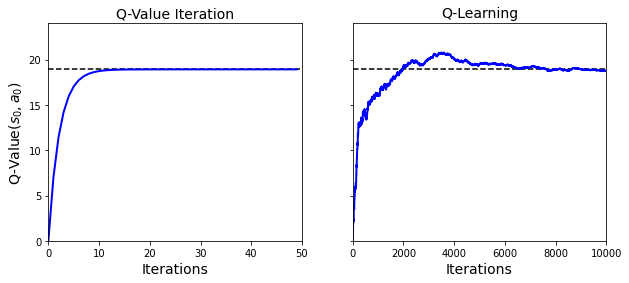

In [ ]:
true_Q_value = history1[-1, 0, 0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)

for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])


# Deep Q-network

In [50]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

# CartPole V1

In [10]:
env = gym.make('CartPole-v1')
input_shape = env.observation_space.shape
n_outputs = env.action_space.n
input_shape, n_outputs

((4,), 2)

# DQN Model

In [52]:
model = keras.models.Sequential([
    keras.layers.Dense(32, activation='elu', input_shape=input_shape),
    keras.layers.Dense(32, activation='elu'),
    keras.layers.Dense(n_outputs)
])

# Policy

In [21]:
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_value = model.predict(state[np.newaxis])
        return np.argmax(Q_value[0])

# Reverb Memory

In [54]:
# (obs, action, reward, next_obs, done)
replay_memory = deque(maxlen=3000)

In [19]:
#Reverb Memory to Experience [states, actions, rewards, next_obs, dones] ( apply batch )
def sample_experience(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    #각 column 들을 각 배열로 바꾸는 과정
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)
    ]
    return states, actions, rewards, next_states, dones

In [20]:
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

# DQN Train Step

In [57]:
batch_size = 32
discount_rate = 0.95 # gamma
optmizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences # 5, batch_size, 1
    next_Q_values = model.predict(next_states) #batch_size, n_actions
    max_next_Q_values = np.max(next_Q_values, axis=1) #batch_size , 1
    target_Q_values = (
        rewards + 
        (1 - done) * discount_rate * max_next_Q_values) #batch_size, 1
    target_Q_values = target_Q_values.reshape(-1, 1) # batch_size,
    mask = tf.one_hot(actions, depth=n_outputs) # batch_size, n_actions
    with tf.GradientTape() as tape:
        all_Q_values = model(states) #batch_size, 1 -> batch_size, n_actions
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True) # batch_size, 1
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values)) #1,
    grads = tape.gradient(loss, model.trainable_variables)
    optmizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

# DQN Train

In [58]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = [] 
best_score = 0

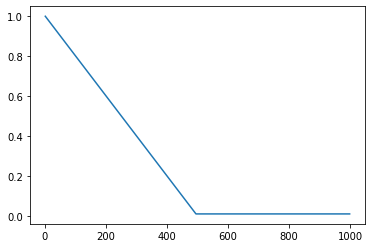

In [59]:
epsilon = np.array([max(1-y/500, 0.01) for y in range(1, 1000)])
plt.plot(np.arange(1, 1000), epsilon)
plt.show()

In [60]:
for episode in range(600):

    obs = env.reset()
    #200 step 수행후 저장
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01) 
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    #각 에피소드의 최고 step 수를 best_score 에 저장함. (여기선 음수 보상이없고 스텝자체가 보상임)
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, Best Score: {}, eps: {:.3f}".format(episode+1, step + 1, best_score ,epsilon), end="") # Not shown
    # 아마도 deque를 채우고 훈련하는 듯
    if episode > 50:
        training_step(batch_size)

model.set_weights(best_weights)

Episode: 600, Steps: 151, Best Score: 199, eps: 0.010

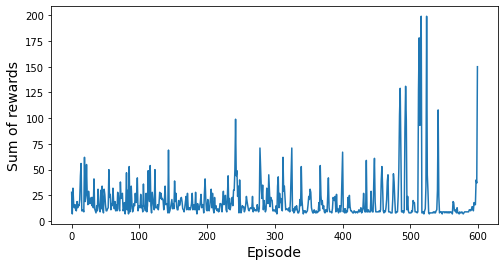

In [63]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [64]:
state = env.reset()
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
print(len(frames))
plot_animation(frames)

200


# Double DQN

In [65]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [66]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=6e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences
    #Predict Model
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    #Target Model
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [67]:
replay_memory = deque(maxlen=2000)

In [68]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, Best SCore: {}, eps: {:.3f}".format(episode, step + 1, best_score, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())
    # Alternatively, you can do soft updates at each step:
    #if episode >= 50:
        #target_weights = target.get_weights()
        #online_weights = model.get_weights()
        #for index in range(len(target_weights)):
        #    target_weights[index] = 0.99 * target_weights[index] + 0.01 * online_weights[index]
        #target.set_weights(target_weights)

model.set_weights(best_weights)

Episode: 599, Steps: 86, eps: 0.010

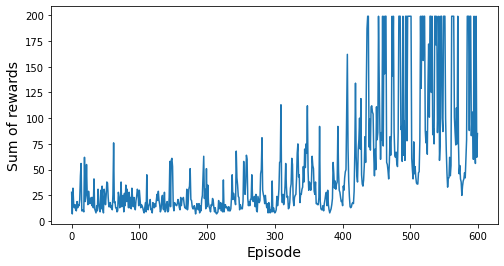

In [69]:
plt.figure(figsize=(8, 4))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()


In [70]:
state = env.reset()
frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)
    
print(len(frames))
plot_animation(frames)

200


# Dueling Double DQN

In [22]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

K = keras.backend
input_states = keras.layers.Input(shape=[4])
hidden1 = keras.layers.Dense(32, activation="elu")(input_states)
hidden2 = keras.layers.Dense(32, activation="elu")(hidden1)

#V(s) 추정
state_values = keras.layers.Dense(1)(hidden2)
#각 행동에 대한 이익 A(s, a) 추정
raw_advantages = keras.layers.Dense(n_outputs)(hidden2)
# 최적의 행동 a* 에 대한 최대 이익을 0 으로 조정
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
#Q(s, a) 추정
Q_values = state_values + advantages
model = keras.models.Model(inputs=[input_states], outputs=[Q_values])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [23]:
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=7.5e-3)
loss_fn = keras.losses.Huber()

def training_step(batch_size):
    experiences = sample_experience(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards + 
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [24]:
replay_memory = deque(maxlen=2000)

In [25]:
env.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

rewards = []
best_score = 0

for episode in range(600):
    obs = env.reset()    
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="")
    if episode >= 50:
        training_step(batch_size)
        if episode % 50 == 0:
            target.set_weights(model.get_weights())

model.set_weights(best_weights)

Episode: 599, Steps: 200, eps: 0.010

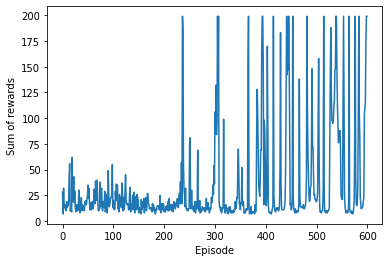

In [26]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Sum of rewards")
plt.show()

In [29]:
env.seed(42)
state = env.reset()

frames = []

for step in range(200):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

print(len(frames))
plot_animation(frames)

200


In [28]:
env.close()